# EDA species imbalance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/13 02:20:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/13 02:20:30 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
train = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
train_gcs_path = f"{gcs_path}/{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data
train_df.show(n=3)

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

In [4]:
from pyspark.sql import functions as F

# Transformation
grouped_train_df = (
    train_df.groupBy(["species", "species_id"])
    .agg(F.count("species_id").alias("n"))
    .orderBy(F.col("n").desc())
)

# Action
grouped_train_df.show()

+--------------------+----------+---+
|             species|species_id|  n|
+--------------------+----------+---+
|Styphnolobium jap...|   1369068|823|
|Frangula alnus Mill.|   1360257|793|
|Aria edulis (Will...|   1737559|770|
|Lathyrus oleraceu...|   1741625|700|
|  Bromus sterilis L.|   1414366|674|
|   Lotus hirsutus L.|   1743246|668|
|Scandosorbus inte...|   1737669|662|
|     Hedera helix L.|   1363575|653|
|Oxalis dillenii J...|   1394359|653|
|Calicotome spinos...|   1359160|642|
|Castanea sativa M...|   1358610|638|
|Buxus semperviren...|   1356729|636|
|    Arbutus unedo L.|   1358500|634|
|Pistacia lentiscu...|   1356290|632|
|   Ulmus minor Mill.|   1360607|630|
|Tecomaria capensi...|   1400151|627|
|     Quercus ilex L.|   1357416|626|
|Calamagrostis are...|   1722433|625|
|Pittosporum tobir...|   1394624|625|
|Cercis siliquastr...|   1359162|624|
+--------------------+----------+---+
only showing top 20 rows



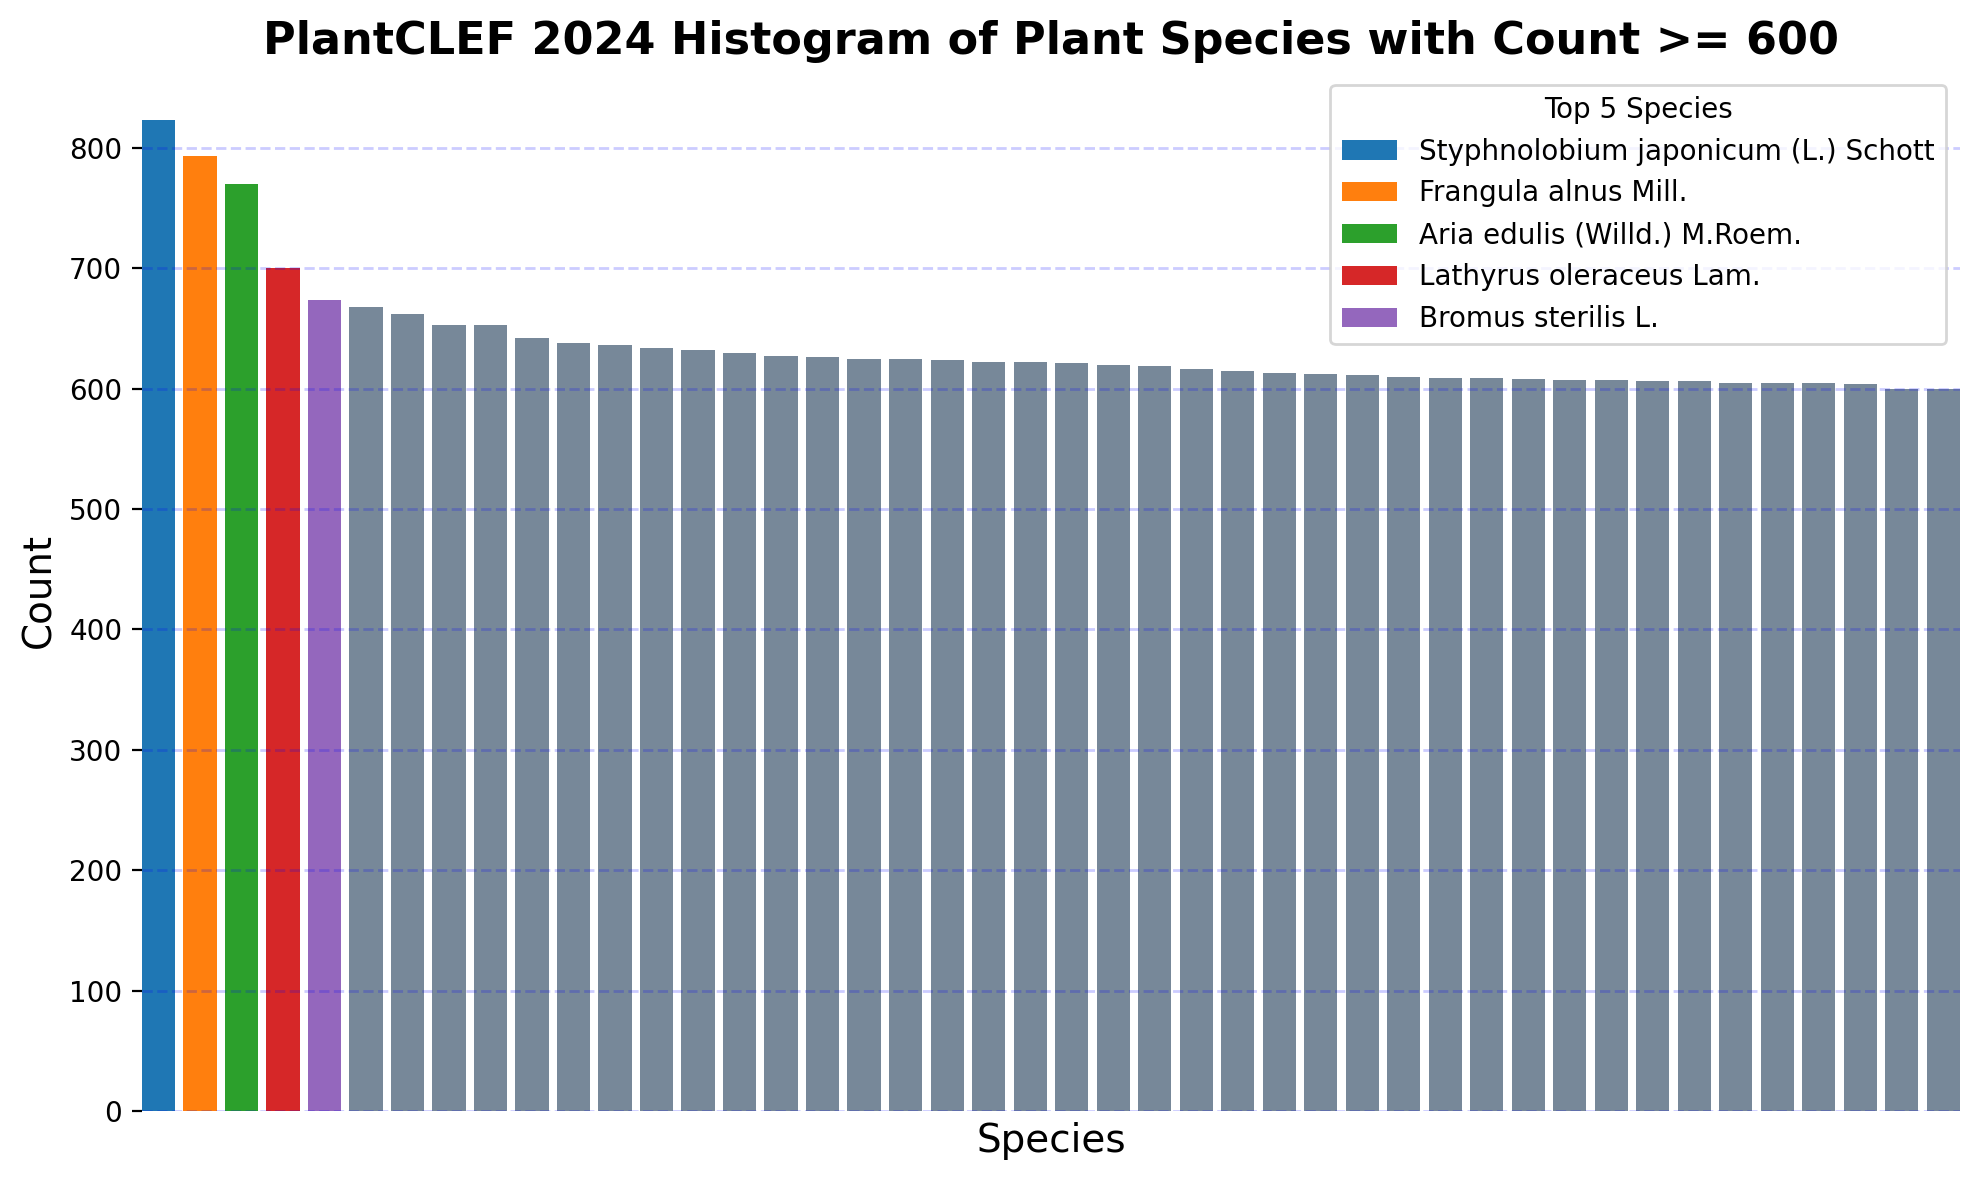

In [6]:
from plantclef.plotting import plot_species_histogram

# Plot species
plot_species_histogram(df=grouped_train_df, species_count=600)

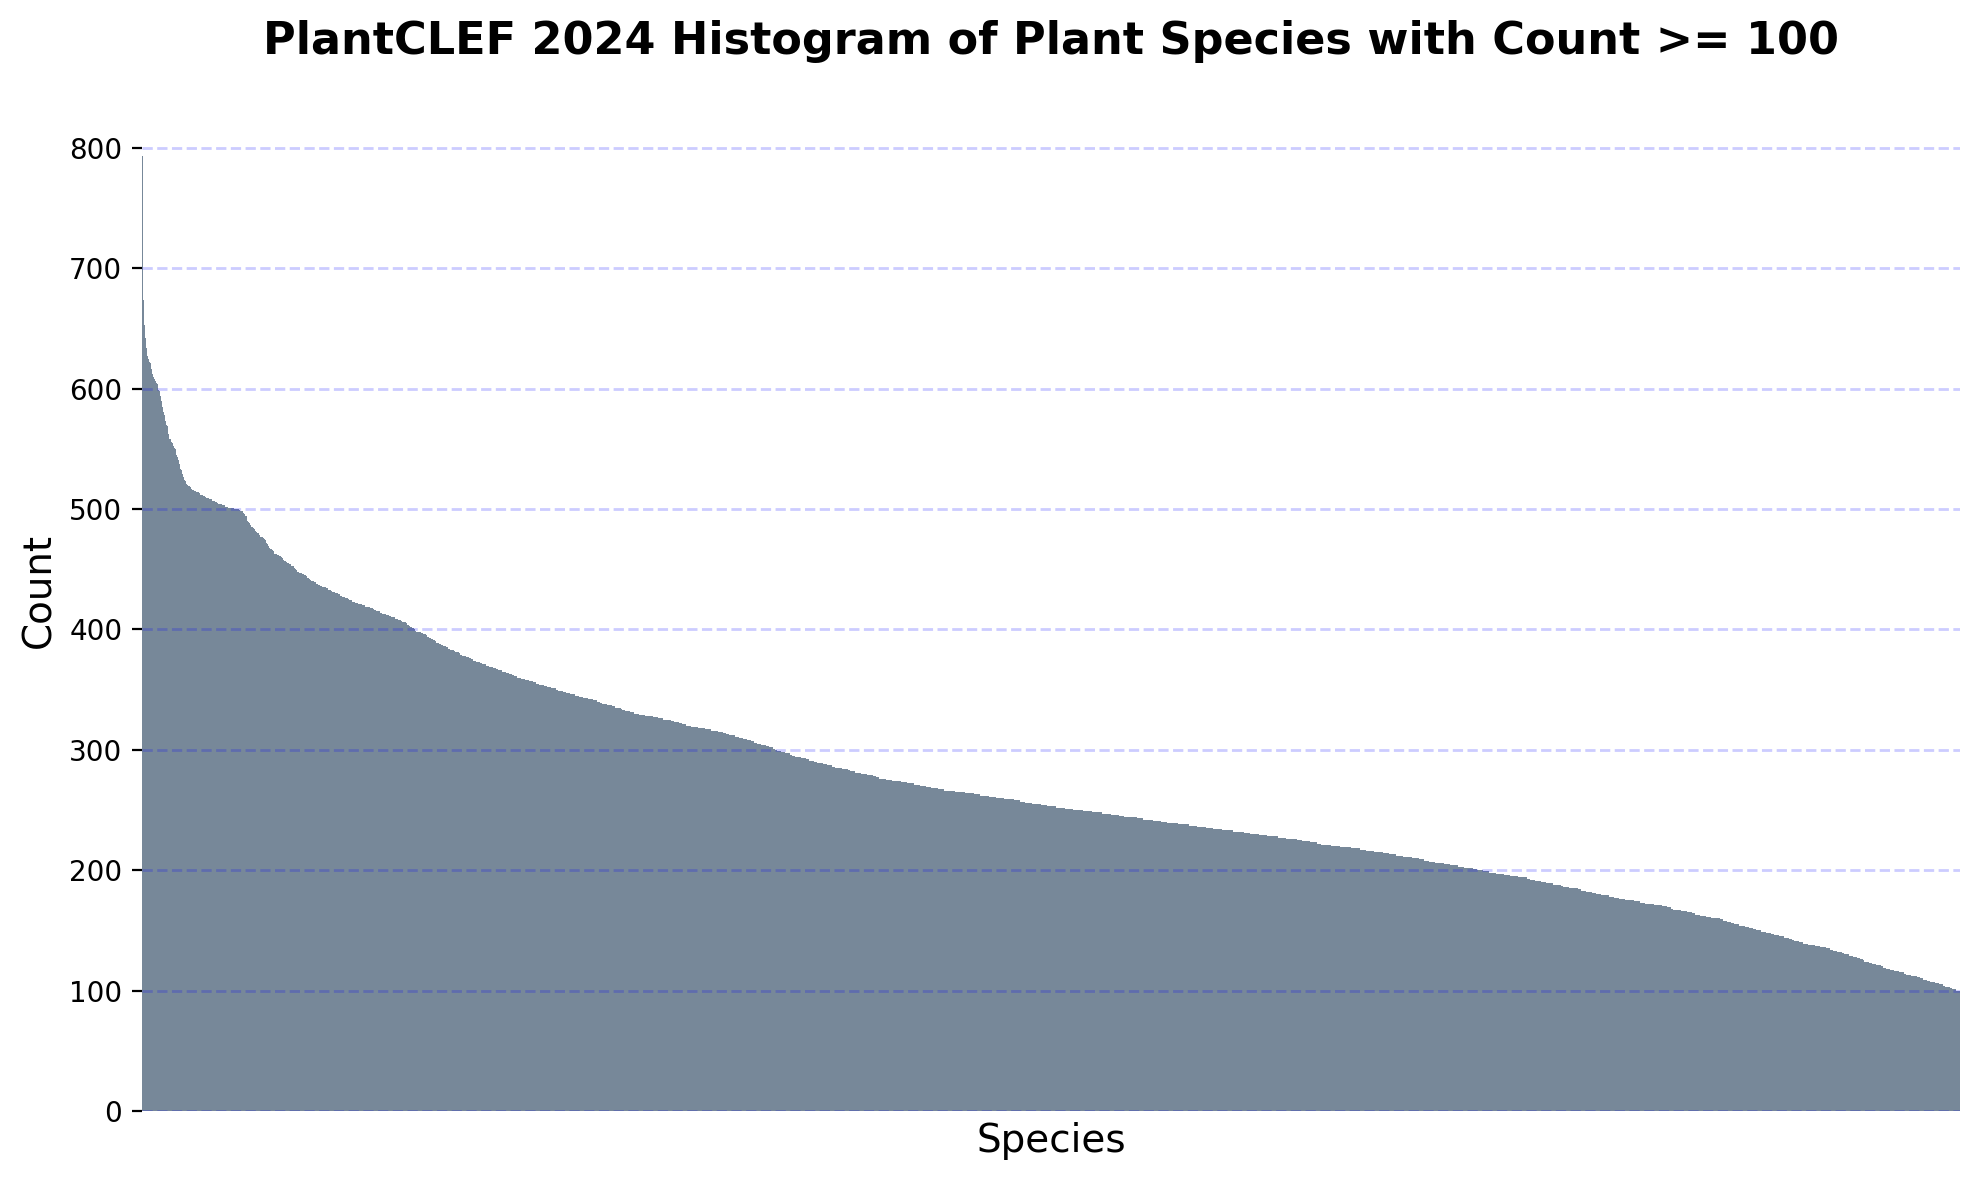

In [7]:
# Plot species with count >= 100
plot_species_histogram(df=grouped_train_df, species_count=100, bar_width=1)

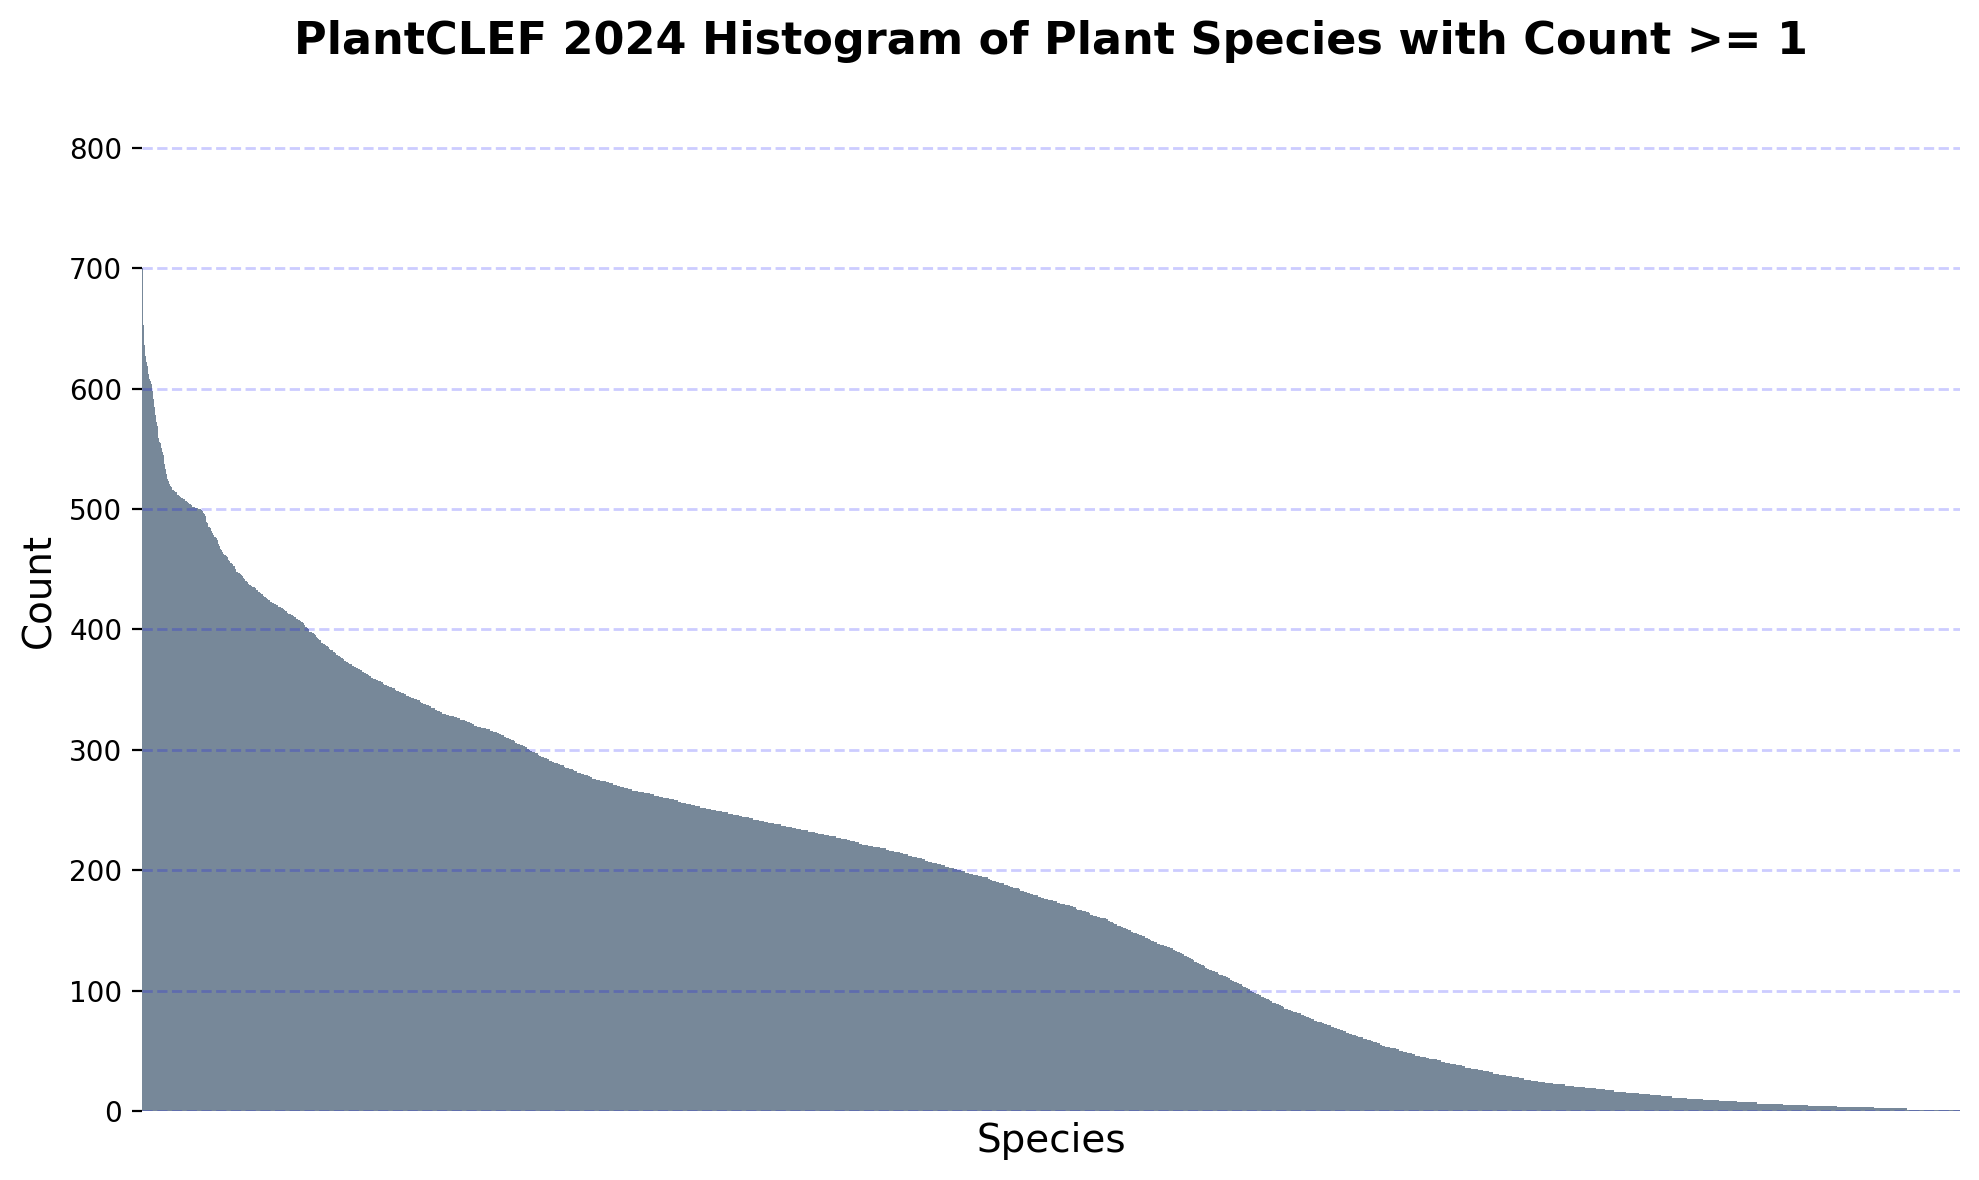

In [8]:
# Plot species with count >= 100
plot_species_histogram(df=grouped_train_df, species_count=1, bar_width=1)

### removed species count

In [32]:
# Param
species_count = 100

# Transformation
grouped_df = (
    train_df.groupBy(["species", "species_id"])
    .agg(F.count("species_id").alias("n"))
    .filter(f"n >= {species_count}")
    .orderBy(F.col("n").desc())
)
grouped_count = grouped_df.count()
print(f"Grouped DF count: {grouped_count}")


joined_df = train_df.join(grouped_df, "species_id", "inner").drop(
    grouped_df["species"], "n"
)
joined_count = joined_df.count()
print(f"Joined DF count: {joined_count}")

Grouped DF count: 4797


Joined DF count: 1323820


In [25]:
joined_df.show()

+----------+--------------------+--------------------+------+----------+--------------------+------------+----------------+---------+-----------------+------------------+---------------+---------+-----------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|species_id|          image_name|                path| organ|    obs_id|             license|     partner|          author| altitude|         latitude|         longitude|gbif_species_id|    genus|     family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|             species|
+----------+--------------------+--------------------+------+----------+--------------------+------------+----------------+---------+-----------------+------------------+---------------+---------+-----------+--------+-----------+--------------------+--------------------+---------+--------------------+--------

In [33]:
# Count removed images from original dataset
total_count = train_df.count()
print(f"Images removed: {total_count - joined_count}")

# Number of species
removed_species_count = grouped_train_df.filter("n >= 100").count()
print(f"Species removed: {removed_species_count}")

Images removed: 84213


Species removed: 4797
